Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

---

# Coursework Assignment (COMP 42315)

The assignment consists of 3 questions. You are required to implement the programming solution containing your code and written answers that explain the implementation and justify the design. For more details, refer to the assignment brief on Blackboard Ultra page 

https://blackboard.durham.ac.uk/ultra/courses/_54354_1/outline/file/_1723127_1

# Instructions (Question 1 and 2)

For Questions 1 and 2, you are asked to perform the following tasks based on the following target website, which contains artificial content designed for this assignment: https://sitescrape.awh.durham.ac.uk/comp42315/

# Question 1 (35 marks)

Please design and implement a solution to crawl the publication title, year and author list of every unique publication record on the target website. Then, please create and display a table that contains these unique records. The table should consist of five columns: the row number in the table, publication title, year, author list, and the number of authors (hint: you will need to develop an algorithm to work this out). The records should be sorted first according to descending year values, then by descending number of author values, and finally by the titles from A to Z. Include the full final result in your Jupyter Notebook. 

[Explain your design and highlight any features in this question’s report part of your Jupyter Notebook in no more than 300 words. (35%)]

### Write your code in the following space.

In [1]:
### Import libraries
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import urllib3 ## Disable the certificate error
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

### Section 1: Define Function Section
## Section 1.1: Functions for web crawling and scraping
def getTopicLinks(url):
    """
    Function to get all topic pages from the publication landing page.
    """
    ## Create a container for the main url
    topics_urls = []
    topics_urls.append(url) # Append the first link

    ## Extract the main URL
    main_url = url[:url.rfind("/")+1]

    ## Get the landing page for publications
    page = requests.get(url, verify=False)
    soup = BeautifulSoup(page.content, "html.parser")
    textOptions = soup.find_all("p", class_="TextOption")
    
    ## Check whether the TextOption class exist
    if textOptions != None:
        
        ## Web page structure contains two TextOption sections
        if len(textOptions) == 2:
            topicsP = textOptions[1] # We select the second one as we wish to access the topics

            ## Get all the topics link
            for topic in topicsP.find_all("a"):
                topic_url = main_url + topic.get("href")
                topics_urls.append(topic_url) # append it to the topic list

            ## Return after successful crawling
            return topics_urls

        else:
            print("Please reinspect the webpage, 'TextOption' has changed.")
            
    ## Print error if could not find
    else:
        print("Could not find 'TextOption' class <p> tag.")

def getResearchPubs(url):
    """
    Function to scrape all the research publication links.
    """
    ## Create a list to hold all publications links
    pub_links = []

    ## Extract the main URL
    main_url = url[:url.rfind("/")+1]
    
    ## Get the page for LinkButton
    page = requests.get(url, verify=False)
    soup = BeautifulSoup(page.content, "html.parser")
    linkButtons = soup.find_all("a", class_="LinkButton")

    ##  Check whether the LinkButton class exist
    if linkButtons != None:
        
        ## Extract each link
        for link in linkButtons:
            pub_links.append(main_url + link.get("href")) # append it to the link list

        return pub_links
    else:
        print("Could not find 'LinkButton' class <a> tag.")
    
def getPubdetails(pub_url):
    """
    Function to get all the details of a research publication.  
    """
    ## Create a placeholder for the return information
    pub_authors_ls = []
    pub_authors_num = None
    pub_title = None
    pub_year = None

    ## Get the publication page details
    page = requests.get(pub_url, verify=False)
    soup = BeautifulSoup(page.content, "html.parser")
    textSmalls = soup.find_all("p", class_="TextSmall")
    
    ##  Check whether the TextSmall class exist
    if textSmalls != None:
        
        ## After inspection, we found out that it is the second last in the 'textSmall' class.
        plainText = textSmalls[-2].text
        uc_authors, uc_title, uc_others = plainText.split('"') # Split by '"' as it only appears around the title
    
        ## Get Author List and Number of Authors
        ## Check if split by " and " and length equals to 2, if not only one author
        ## We use the string from until -1 as we notice that there always will be '.' at the end
        if (len(uc_authors.strip()[:-1].split(" and ")) == 2):
            
            pub_authors_ls = uc_authors.strip()[:-1].replace(" and ", ", ").split(",") # Replace ' and ' with ',' to make splitting easier
            
        else:
            pub_authors_ls = [uc_authors.strip()[:-1]] # Only one author, '[...]' to return as a list
        
        pub_authors_num = len(pub_authors_ls) ## Get the number of authors
        
        ## Get Publication Name
        pub_title = uc_title.strip()[:-1] # Capture everything except the '.' at the end
        
        ## Get Publication Year
        pub_month_year = uc_others.strip().replace(".", "").split(",")[-1].strip() # Extract the last element contain month & year

        ## If it is splitable into month, year
        if len(pub_month_year.split(" ")) != 1:
            pub_year = int(pub_month_year.split(" ")[-1].strip()) # As year always comes at the end
        
        else:
            pub_year = int(pub_month_year)
    
        ## Return as a dictionary
        pubRecord = {"publication_title": pub_title.strip(),
                     "year": pub_year,
                    "authors_list": [pub_authors_ls],
                    "authors_numbers": pub_authors_num}
        
        return pubRecord
        
    else:
        print("Could not find 'TextSmall' class <p> tag.")

## Section 1.2: Functions to manipulate pandas DataFrame
def displayFull(df):
    """
    Function to display all of the DataFrame entries.
    """
    ## Function to display all table elements
    pd.set_option("display.max_rows", df.shape[0]) # set row
    pd.set_option("display.max_columns", df.shape[1]) # set column
    pd.set_option("display.max_colwidth", None) # Prevent column truncation
    display(df)
    ## Reset to defult
    pd.reset_option("display.max_rows")
    pd.reset_option("display.max_columns")
    pd.reset_option("display.max_colwidth")

def swapRow(df, idx1, idx2):
    """
    Function to swap row during algorithmic sorting.
    This function swaps "idx1" position with "idx2".
    """
    temp0, temp1 = df.loc[idx1].copy(), df.loc[idx2].copy() # Create a temporary holder
    df.loc[idx1], df.loc[idx2] = temp1, temp0 # Swap
    
### Section 2: Main Section to Web Crawling and Web Scraping
## It combines all the functions above.
url = "https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_animationandgraphics.htm"

## Store all of the unique publication links
unique_pubs = []

## Get List of Main Topics
for topic_url in getTopicLinks(url):

    ## Get publication links
    for pub_url in getResearchPubs(topic_url):

        ## As url is specific towards the paper despite the topic tags
        if pub_url not in unique_pubs:
            unique_pubs.append(pub_url) # Append unique url into the list

## Get Publication Entry and put into a Record
pub_record = pd.DataFrame()
for pub in unique_pubs:
    pub_entry = pd.DataFrame(getPubdetails(pub))
    pub_record = pd.concat([pub_record, pub_entry], ignore_index=True)

### Section 3: Algorithm to sort the data 
## Sort the Publication Record Year [Decending] -> Number of Authors [Decending] -> Title [A-Z]
sorted = False
num_entries = pub_record.shape[0]-1 
while not sorted:
    sorted = True # Breaks the sort loop if all the elements is sorted

    ## Run through all the rows in the DataFrame
    for i in range(num_entries):
        ## If i+1 year is more than the i -> swap
        if(pub_record.loc[i, "year"] < pub_record.loc[i+1, "year"]):
            sorted = False
            swapRow(pub_record, i, i+1)
            
        ## If year equals, sort by number of authors. If i+1 number of authors is more than i -> swap
        elif (pub_record.loc[i, "year"] == pub_record.loc[i+1, "year"])  and (pub_record.loc[i, "authors_numbers"] < pub_record.loc[i+1, "authors_numbers"]):
            swapRow(pub_record, i, i+1)
            sorted = False
            
        ## If year and number of authors are equal, sort by alphabetical order [A-Z]
        elif (pub_record.loc[i, "year"] == pub_record.loc[i+1, "year"])  and (pub_record.loc[i, "authors_numbers"]== pub_record.loc[i+1, "authors_numbers"]) and (pub_record.loc[i, "publication_title"].lower()  > pub_record.loc[i+1, "publication_title"].lower() ):
            swapRow(pub_record, i, i+1)
            sorted = False

## After sorting we add row number and rearrange it
pub_record["row_number"] = range(1, pub_record.shape[0] + 1) # Add row number column
pubRecord = pub_record.iloc[:,[4,0,1,2,3]] # Rearrange to make the row_number at front
displayFull(pubRecord) # Display the full data

,row_number,publication_title,year,authors_list,authors_numbers
0,1,A Video-Based Augmented Reality System for Human-in-the-Loop Muscle Strength Assessment of Juvenile Dermatomyositis,2023,"[Kanglei Zhou, Ruizhi Cai, Yue Ma, Qingqing Tan, Xinning Wang, Jianguo Li, Hubert P. H. Shum, Frederick W. B. Li, Song Jin, Xiaohui Liang]",10
1,2,A Mixed Reality Training System for Hand-Object Interaction in Simulated Microgravity Environments,2023,"[Kanglei Zhou, Chen Chen, Yue Ma, Zhiying Leng, Hubert P. H. Shum, Frederick W. B. Li, Xiaohui Liang]",7
2,3,Correlation-Distance Graph Learning for Treatment Response Prediction from rs-fMRI,2023,"[Xiatian Zhang, Sisi Zheng, Hubert P. H. Shum, Haozheng Zhang, Nan Song, Mingkang Song, Hongxiao Jia]",7
3,4,Unaligned 2D to 3D Translation with Conditional Vector-Quantized Code Diffusion using Transformers,2023,"[Abril Corona-Figueroa, Sam Bond-Taylor, Neelanjan Bhowmik, Yona Falinie A. Gaus, Toby P. Breckon, Hubert P. H. Shum, Chris G. Willcocks]",7
4,5,Region-Based Appearance and Flow Characteristics for Anomaly Detection in Infrared Surveillance Imagery,2023,"[Yona Falinie A. Gaus, Neelanjan Bhowmik, Brian K. S. Isaac-Medina, Hubert P. H. Shum, Amir Atapour-Abarghouei, Toby P. Breckon]",6
5,6,Hard No-Box Adversarial Attack on Skeleton-Based Human Action Recognition with Skeleton-Motion-Informed Gradient,2023,"[Zhengzhi Lu, He Wang, Ziyi Chang, Guoan Yang, Hubert P. H. Shum]",5
6,7,Focalized Contrastive View-Invariant Learning for Self-Supervised Skeleton-Based Action Recognition,2023,"[Qianhui Men, Edmond S. L. Ho, Hubert P. H. Shum, Howard Leung]",4
7,8,Hierarchical Graph Convolutional Networks for Action Quality Assessment,2023,"[Kanglei Zhou, Yue Ma, Hubert P. H. Shum, Xiaohui Liang]",4
8,9,INCLG: Inpainting for Non-Cleft Lip Generation with a Multi-Task Image Processing Network,2023,"[Shuang Chen, Amir Atapour-Abarghouei, Edmond S. L. Ho, Hubert P. H. Shum]",4
9,10,Interaction-Aware Decision-Making for Automated Vehicles using Social Value Orientation,2023,"[Luca Crosato, Hubert P. H. Shum, Edmond S. L. Ho, Chongfeng Wei]",4


### Write your description in the following space.

The code is structured in two main parts: web crawling and scraping, and algorithmic sorting. Web crawling design revolves around collecting relative links within the topic section before creating a list of URLs, which is done by the “getTopicLinks” function. With all the topic URLs acquired, another function runs through each page to collect link button relative links and create a workable URL. Loops were used to combine these two functions. Additionally, these functions contain error checking to verify whether the structure of the website has changed from the structure or not. If the structure changes, it will print out a specific error message. During the crawling process, unique URLs will be stored and further scrapped out the required contents with “getPubdetails”.  This function extracts the plain text section of each publication and breaks the information down into a dictionary, containing the publication title, year, authors list, and authors numbers. 

The returned dictionary will be converted into pandas DataFrame, which this DataFrame will continuously add up new rows of data until all the unique publication URLs have been iterated over. A sorting algorithm is used to sort the DataFrame by year (descending), number of authors (descending), and publication title (A-Z), accordingly. This sorting algorithm is based on the bubble sort algorithm concept with a time complexity of O(n^2). It will continuously iterate through the DataFrame rows and swap rows if one of the conditions is met. Only when all the rows are sorted will the algorithm stop, breaking from the loop. Later, a row number column is added. To visualize the whole table, “displayFull” disables the limitation of the display column width and the dimensions. This function is preferred over printing as printing could result in inconsistent formatting. 


<b>Word Count: </b> (288 words)

# Question 2 (30 marks)

For this question, you should record the year, number of citations, topic, and number of Links, Downloads, and Online Resources (LDOR) for each journal paper listed on the scraping website and store these in a dataframe. Take care to filter the elements for uniqueness before producing the analysis. Produce a table showing the mean and variance of citations per journal publication in each topic and print it legibly in your submission. In Figure 1, you should show the mean and variance of citations per year across all journal publications for each topic. In Figure 2, you should show the number of LDOR against the number of citations for each journal publication. Each figure should be legible and have appropriate labels. 

[Explain your design and highlight any features in this question’s report part of your Jupyter Notebook in no more than 300 words. (30%)]

### Write your code in the following space.

Loading BokehJS ...

No 'Journal Papers' section within this url (https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_environmentcapturing.htm).
No 'Journal Papers' section within this url (https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_literaturereview.htm).

 ---------- Table: Mean and Variance of Citations per Publication ----------


,topics,mean,variance
0,3D Surfaces,13.40,74.80
1,Action Recognition,35.00,1289.00
2,Animation and Graphics,25.67,842.79
3,Biomedical Engineering,33.90,2448.10
4,Biometrics,16.38,313.98
5,Computational Intelligence,18.00,223.00
6,Crowd Simulation,15.40,139.30
7,Depth and 3D Estimation,59.40,4432.80
8,Facial Feature Analysis,10.00,74.50
9,Hand Modelling,5.33,2.33



 ---------- Figure 1: Topics Mean and Variance of Citations Per Year ----------


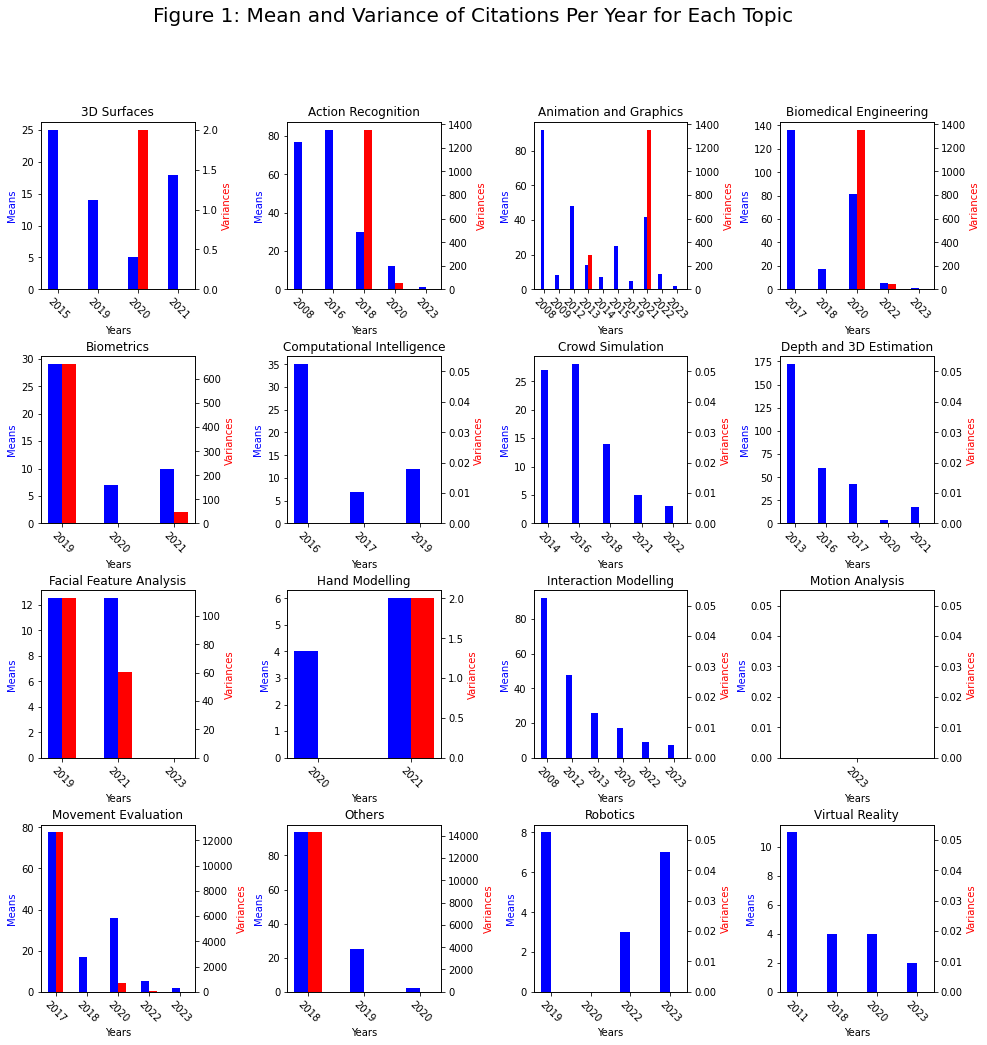


 ---------- Figure 2: Number of LDORs vs Number of Citations ----------


In [2]:
### Import libraries
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import urllib3 ## Disable the certificate error
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool

### Section 1: Define Function Section
## Section 1.1: Functions for web crawling
## This function was defined in Question 1 section.
def getTopicLinks(url):
    """
    Function to get all topic pages from the publication landing page.
    """
    ## Create a container for the main url
    topics_urls = []
    topics_urls.append(url) # Append the first link

    ## Extract the main URL
    main_url = url[:url.rfind("/")+1]

    ## Get the landing page for publications
    page = requests.get(url, verify=False)
    soup = BeautifulSoup(page.content, "html.parser")
    textOptions = soup.find_all("p", class_="TextOption")
    
    ## Check whether the TextOption class exist
    if textOptions != None:
        
        ## Web page structure contains two TextOption sections
        if len(textOptions) == 2:
            topicsP = textOptions[1] # We select the second one as we wish to access the topics

            ## Get all the topics link
            for topic in topicsP.find_all("a"):
                topic_url = main_url + topic.get("href")
                topics_urls.append(topic_url) # append it to the topic list

            ## Return after successful crawling
            return topics_urls

        else:
            print("Please reinspect the webpage, 'TextOption' has changed.")
            
    ## Print error if could not find
    else:
        print("Could not find 'TextOption' class <p> tag.")

def getJournalpub(url):
    """
    Function to get publications title, topic, and URLs in the Journal Section in each Topic page.
    """
    ## If the Journal Section does not exist, this function will print out that it cannot be found.
    curTopic = None # Current URL topic
    topic_journals = [] # The list of list to be return
    titles_list = []
    urls_list = []
    
    ## Extract the main URL
    main_url = url[:url.rfind("/")+1]
    
    ## Get page Details
    page = requests.get(url, verify=False)
    soup = BeautifulSoup(page.content, "html.parser")
    
    ## Check if Journal Paper Section exist before proceeding
    journalHeader = soup.find("h2", id="Journal Papers") ## locate the Header
    if journalHeader != None:
        ## Get the current Topic name
        textOptions = soup.find_all("p", class_="TextOption")
        topicSection = textOptions[1]
        topic_list = topicSection.find_all(string=True, recursive=False) # recursive = False prevents its to look into children tags
        for element in topic_list:
            if element.strip() != "/":
                curTopic = element.replace("Topic:","").replace("/","").strip() # Remove 'Topic:' or '/' if exist then strip white space
                # print(curTopic) # Checking the extracted topic
    
        ## Get the section that contains all the Journal Papers
        ## We use find_next to find subsequent <div> following the 'Journal Paper' <h2> tag
        journalSection = journalHeader.find_next("div", style={"margin-left: var(--size-marginleft)"}) 
        titleSections = journalSection.find_all("span", class_="PublicationTitle", style={"font-size:16px;"})
        
        ## Get Journal Paper names from this Topic
        for a_title in titleSections:
            a_title.span.decompose() # destroys internal span for the title commentary
            a_journal = a_title.text.strip() # Extract the topic
            titles_list.append(a_journal)
    
        ## Get Journal Links from this Topic
        for a_link in journalSection.find_all("a", class_="LinkButton"):
            journal_url = main_url + a_link.get("href")
            urls_list.append(journal_url)
    
        ## Combine all the details in to a list
        ## Each entry - [ Journal Paper Title, Research Topic, Journal URL]
        for idx in range(len(titles_list)):
            topic_journals.append([titles_list[idx], curTopic, urls_list[idx]])

        return topic_journals # return topic journals
    
    else:
        print(f"No 'Journal Papers' section within this url ({url}).")

## Section 1.2: Functions to construct data frame and webscraping
def isUnique_title(entries_ls, title):
    """
    Function to identify whether a title is unique or not as one title could have multiple topics.
    """
    ## If no entires -> unique
    if len(entries_ls) != 0:
        ## loop through the list
        for entry in entries_ls:
            if entry["title"] == title:
                return False # Return False if its already exist
        return True # return True if unique
    else:
        return True # No entries = unique

def entryLoc(entries_ls, title):
    """
    Function to find the location of a specific journal publication title within list of list.
    """
    index = 0
    for entry in entries_ls:
        if entry["title"] == title:
            return index
        index += 1
    print("Title is not within the list of dict entries.")

def getJournaldet(url):
    """
    Function to get specificed journal details.
    """
    ## Extract details from each links
    ## Details to return
    pub_title = None
    citations_num = None
    pub_year = None
    resources_num = None
    
    ## Get page content
    page = requests.get(url, verify=False)
    soup = BeautifulSoup(page.content, "html.parser")
    
    ### Get the Title and the Citation Number
    titleSection = soup.find("h1", style={"text-align: center"}) # We use find as there should be one <h1> tag
    
    ## Proceed If the title header <h1> exist
    if titleSection != None:
        ## Extract the citations
        citationSection = titleSection.find("span", style={"color:orange; font-size:16px;"})
        if citationSection != None:
            if citationSection.text.replace("Citation:","").replace("#","").strip() != "":
                citations_num = int(citationSection.text.replace("Citation:","").replace("#","").strip())
            else:
                citations_num = None
        else:
            citations_num = None

        ## Extraction of the Title
        titleSection_clone = titleSection # We clone to destroy the <span> for easier extraction
        titleSection_clone.span.decompose()
        pub_title = titleSection_clone.text.strip()

        ## Extraction of Year
        authorSection = soup.find("h2", style={"text-align: center"}) # We use find as its the first <h2> tag to return
        pub_year = int(authorSection.text.split()[-1])

        ## Extraction of Number links and resources
        potentialSections = soup.find_all("div", style={"margin-left: var(--size-marginleft)"})
        resourcesSection = potentialSections[1]
        count = 0
        for imgThumb in resourcesSection.find_all("div", class_="ImgThumbnailDiv"):
            count += 1
        for yt_vid in resourcesSection.find_all("iframe", class_="youtube-player"):
            count += 1
        resourcesNum = count

        ## Combine into a dict
        journalDet = {"title": pub_title,
                      "year": pub_year,
                      "citations_number": citations_num,
                      "LDOR_number": resourcesNum}

        ### Return extracted information
        return journalDet
    
    else:
        print("Could not find title header with <h1> tag.")

## Function to get all topic pages from the publication landing page.
## This function was defined in Question 1 section. Hence, we could call it in this question.
def displayFull(df):
    """
    Function to display all of the DataFrame entries.  
    """
    ## Function to display all table elements
    pd.set_option("display.max_rows", df.shape[0]) # set row
    pd.set_option("display.max_columns", df.shape[1]) # set column
    pd.set_option("display.max_colwidth", None) # Prevent column truncation
    display(df)
    ## Reset to defult
    pd.reset_option("display.max_rows")
    pd.reset_option("display.max_columns")
    pd.reset_option("display.max_colwidth")
        
### Section 2: Main Section to Web Crawling and Web Scraping
## Section 2.1: Extract journal publication title, topics, and URL
url = "https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_animationandgraphics.htm"
unclean_pubs = [] # Refered to as unclean as one title could have multiple topics
for link in getTopicLinks(url): # getTopicLinks(url) function is reused from question 1
    ## To filter out topics with no journal publications
    if getJournalpub(link) != None:
        for a_pub in getJournalpub(link):
            unclean_pubs = unclean_pubs + [a_pub]

## Section 2.2: Extract details and combine it into list of dictionaries
journal_pubs = []
for a_pub in unclean_pubs:
    ## Beaking down 'a_pub' for readability
    title, a_topic, a_url = a_pub[0], a_pub[1], a_pub[2]
    ## Check if unqiue -> append
    if isUnique_title(journal_pubs, title):
        a_journal_details = getJournaldet(a_url)
        journal_entry = {"title": title,
                         "year": a_journal_details["year"],
                         "citations_number": a_journal_details["citations_number"],
                         "topics": [a_topic],
                         "LDOR_number": a_journal_details["LDOR_number"],
                         "url": a_url}
        journal_pubs.append(journal_entry)
        
    ## if not unique -> update topics
    else:
        ## if the title exist within the created list
        if entryLoc(journal_pubs, title) != None:
            loc = entryLoc(journal_pubs, title)
            a_entry = journal_pubs[loc]
            if (title == a_entry["title"]) and (a_topic not in a_entry["topics"]):
                a_entry["topics"].append(a_topic)         

## Section 2.3: DataFrame creation and Pivot Table creation
journalPub = pd.DataFrame(journal_pubs) # "Environment Capturing" and "Literature Review" have no Journal papers section
## We fill citations_number by 0 assuming that the value is not missing but there is really no citations for that publication.
journalPub.fillna(0, inplace = True)
# displayFull(journalPub) # Display journal publication

### Table for Mean and Variances of citations per publication
exp_journalPub = journalPub.explode("topics") # exploded journal pubs as "topics" is in listed format
exp_journalPub = exp_journalPub.drop_duplicates() # drop any possible duplicates (There should be none)

## Create a pivot table
## We use 'dropna = False' and fill_value=0' to ensure that the 'Motion Analysis'
topic_meanVar = exp_journalPub.pivot_table(index = ["topics"], values = "citations_number", 
                                                aggfunc = ['mean', 'var'], dropna = False, 
                                                fill_value = 0).reset_index().round(2)
topic_meanVar.columns = ['topics', 'mean', 'variance']
print("\n", "-" * 10, "Table: Mean and Variance of Citations per Publication", "-" * 10)
displayFull(topic_meanVar) # This 'displayFull' code is reused from Question 1

## Section 3: Plotting Figure 1 and Figure 2
## Section 3.1: Mean and variance of citations per publication in each topic 
topics_data = []
## Get mean and variance of each topic across the years and put it in a list
for topic, group in exp_journalPub.groupby("topics"):
    ## For each topic we group again by "year" and "citations number"
    ## As some year have one entry, it will result in variance NaN. We fill NaN with 0.
    topic_yearStat = group.groupby("year")["citations_number"].agg(["mean", "var"]).fillna(0).round(2)
    ## Append it as a list of list [topic, year, [mean], [var]]
    topics_data.append([topic, list(topic_yearStat.index), list(topic_yearStat["mean"]), list(topic_yearStat["var"])]) 
    
rows, cols = 4, 4 # define plotting matrix
topic_idx = 0 # data set indexing
width = 0.25 # bar width
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(16, 16), gridspec_kw={"hspace":0.4, "wspace":0.6})
fig.suptitle("Figure 1: Mean and Variance of Citations Per Year for Each Topic", fontsize = 20)
years_range = range(journalPub["year"].min(), journalPub["year"].max() + 1)

## Loop through each plot
for row in range(rows):
    for col in range(cols):
        data = topics_data[topic_idx]
        topic, years, means, variances = data[0], data[1], data[2], data[3]
        years = list(map(str, years))
        
        ## Plot the mean axis
        ax[row, col].bar(years, means, color = "blue", width = width, label = "Means")
        ax[row, col].set_ylabel("Means", color="blue")
        ax[row, col].set_ylim(ymin=0)
        
        ## Secondary axis the variance axis
        ax2 = ax[row, col].twinx() # add a twin
        ax2.bar(np.arange(len(years)) + width, variances, color = "red", width = width, label = "Variances")
        ax2.set_ylabel("Variances", color="red")
        ax2.set_ylim(ymin=0)
        
        ## Modifying the plot
        ax[row, col].set_title(topic)
        ax[row, col].set_xlabel("Years")
        ax[row, col].set_xticks(np.arange(len(years)) + width/2)
        ax[row, col].tick_params(axis="x", labelrotation=-45)
        
        topic_idx += 1 # move to next data set

print("\n", "-" * 10, "Figure 1: Topics Mean and Variance of Citations Per Year", "-" * 10)
plt.show()    

## Section 3.2: Number of LDORs against Number of Citations for each publication
fig2_data = journalPub[["title", "topics", "citations_number", "LDOR_number"]].fillna(0) # Extract data
source = ColumnDataSource(fig2_data) # Change the dataFrame into ColumnDataSource
TOOLS = "pan, wheel_zoom, box_zoom, reset, hover, save" # Defining the tools 
TOOLTIPS = [
    ("Title", "@title"),
    ("Topics", "@topics"),
    ("Citations", "@citations_number"),
    ("LDORs", "@LDOR_number")]

## Customizing the plot
fig2_plot = figure(tools = TOOLS, tooltips = TOOLTIPS)
fig2_plot.width = 800
fig2_plot.height = 500

## Ploting legends
fig2_plot.title.text = "Figure 2: Number of LDORs vs Number of Citations"
fig2_plot.title.align = "center"
fig2_plot.xaxis.axis_label = "Number of Citations"
fig2_plot.yaxis.axis_label = "Number of LDORs"

fig2_plot.scatter(x = "LDOR_number", y = "citations_number", source = source , 
                  alpha = 0.6, size = 10)
print("\n", "-" * 10, "Figure 2: Number of LDORs vs Number of Citations", "-" * 10)
show(fig2_plot) 

### Write your description in the following space.

This code is divided into two main sections: web crawling and scraping, and visualization. During the web crawling process, the "getJournalPub" function extracts all publication titles and URLs under the Journal Papers section, which was collected by the "getTopicLinks" crawler. The “getJournalPub” function checks for the journal paper section, pages without this section will be notified by printed messages. Thus, "Environment Capturing" and "Literature Review" topics are not added to this analysis totaling 16 topics. After all the scraping processes have been finished, unique publications, which are indicated by unique URLs, are created into a DataFrame. 


After analyzing the scraped information, we observed that certain publications do not have citation numbers. As most of the journal publications that are missing are relatively recent, we assume that the number of citations is not missing but zero. Therefore, the missing value "NaN" is replaced by 0. For Motion Analysis, the publication exists but does not have a citation number, so it is considered in this analysis. The pivot table function is used to create a table of mean and variance, before being displayed. For Figure 1, bar graphs of all the topics' mean and variance across the years are plotted into an array. The choice of an array of bar subplots is to be able to make the mean and variance of all the topics visible. From the subplots, it can be identified that in some years for a topic, there is only one publication for that year. Therefore, the variance calculated is zero. As for Figure 2, a scatter plot of the number of LDOR versus the number of citations for each publication is generated with the Bokeh library. An annotated tool is integrated into the scatter plot to provide details of each publication when hovering over the points.


<b>Word Count: </b> (298 words)

# Instructions (Question 3)

For Question 3, you are asked to perform the task based on the target dataset (finance_dataset.csv), which you can download separately on Blackboard Ultra (refer link below). The file contains artificial content designed for this assignment.

https://blackboard.durham.ac.uk/ultra/courses/_54354_1/outline/file/_1723128_1

DO NOT CHANGE THE FILE NAME FOR THE CONSIDERED DATASET

# Question 3 (35 marks)

The Cross-Sectional Asset Pricing dataset includes 210 features. The target variable is 'excessret', a firm's excess return between the current and the previous quarter. You are required to work on a subset that includes the 'defined features' and the 'target variable' by performing preprocessing (in the subset, there will be 11 features in total including target variable). You are required to extract the 'defined features' that are as indicated below: 

defined_columns = ['high52', 'mom12m', 'mom6m', 'maxret', 'mom12moffseason', 'realizedvol', 'idiovolaht', 'zerotrade', 'indretbig', 'returnskew']

Design and implement the solution to analyze the complex relationship between defined features and the firm's excess return between the current and the previous quarter. Highlight and visualise the attributes with the highest probabilistic relationship with the target variable. Justify the design choice and showcase the findings using an appropriate visualisation tool. 

[Explain your design and highlight any features in this question's report part of your Jupyter Notebook in no more than 400 words. (35%)]


### Write your code in the following space.

Dimensions:  (500, 11)

 ---------- Check Data Type ----------
excessret          float64
high52             float64
mom12m             float64
mom6m              float64
maxret             float64
mom12moffseason    float64
realizedvol        float64
idiovolaht         float64
zerotrade          float64
indretbig          float64
returnskew         float64
dtype: object

 ---------- Check Missing Values (NA) ----------
excessret          False
high52             False
mom12m             False
mom6m              False
maxret             False
mom12moffseason    False
realizedvol        False
idiovolaht         False
zerotrade          False
indretbig          False
returnskew         False
dtype: bool

 ---------- Summary Statistics Table ----------


,count,mean,std,min,25%,50%,75%,max
excessret,500.0,0.065362,0.113833,-3.189280e-01,-4.002000e-03,4.938600e-02,1.176867e-01,0.554650
high52,500.0,0.822815,0.181922,2.392638e-01,7.080895e-01,8.573567e-01,9.437912e-01,1.382140
mom12m,500.0,-0.019889,0.371154,-7.329010e-01,-2.476829e-01,-6.681741e-02,1.125461e-01,2.063720
mom6m,500.0,0.108378,0.255572,-4.090231e-01,-4.321944e-02,6.338909e-02,2.279047e-01,1.580645
maxret,500.0,-0.054409,0.036996,-3.477538e-01,-6.634666e-02,-4.352695e-02,-3.118531e-02,-0.006076
mom12moffseason,500.0,0.018903,0.039558,-9.176746e-02,-5.117328e-03,1.181651e-02,3.721887e-02,0.190136
realizedvol,500.0,-0.023312,0.011748,-8.981903e-02,-2.847900e-02,-2.097717e-02,-1.539543e-02,-0.004757
idiovolaht,500.0,-0.026259,0.013266,-1.273456e-01,-3.273918e-02,-2.303390e-02,-1.735720e-02,-0.009000
zerotrade,500.0,0.002000,0.021008,1.553084e-09,1.148040e-08,1.827145e-08,2.750040e-08,0.333333
indretbig,500.0,0.046176,0.053658,-8.933780e-02,8.375047e-03,3.814942e-02,7.783812e-02,0.250519



 ---------- Scatter Matrix ----------


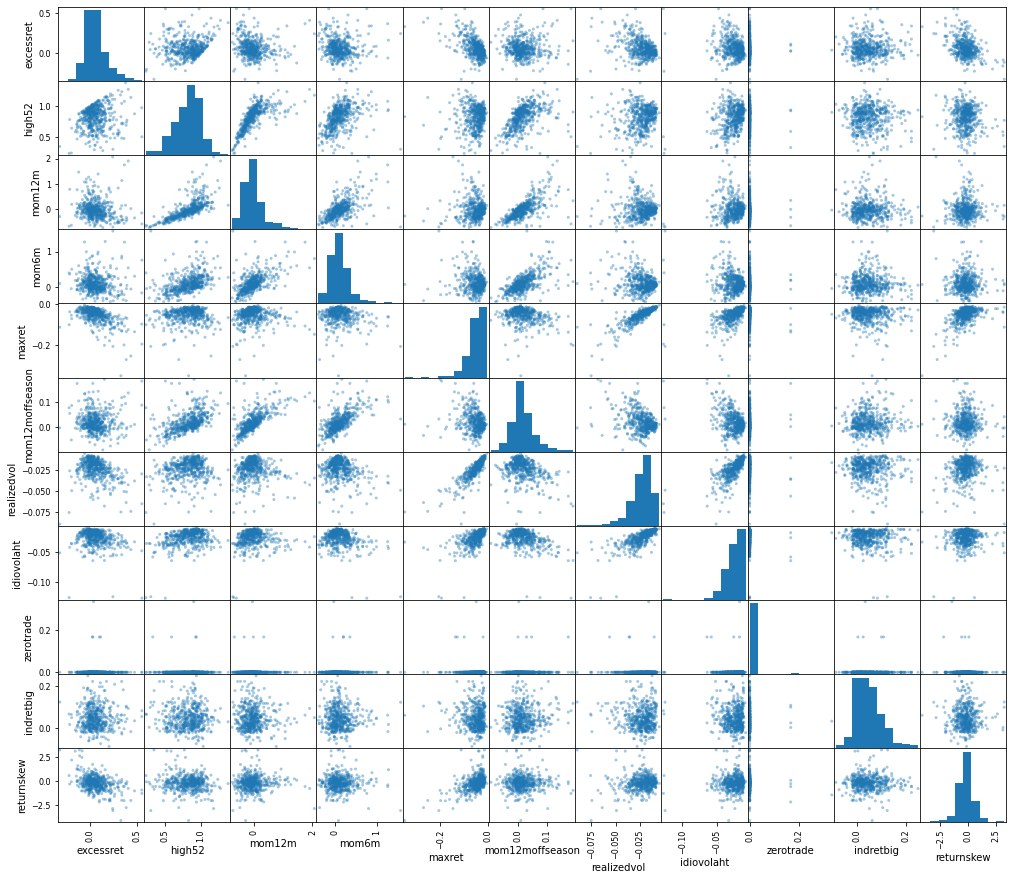


 ---------- Histogram Plot ----------


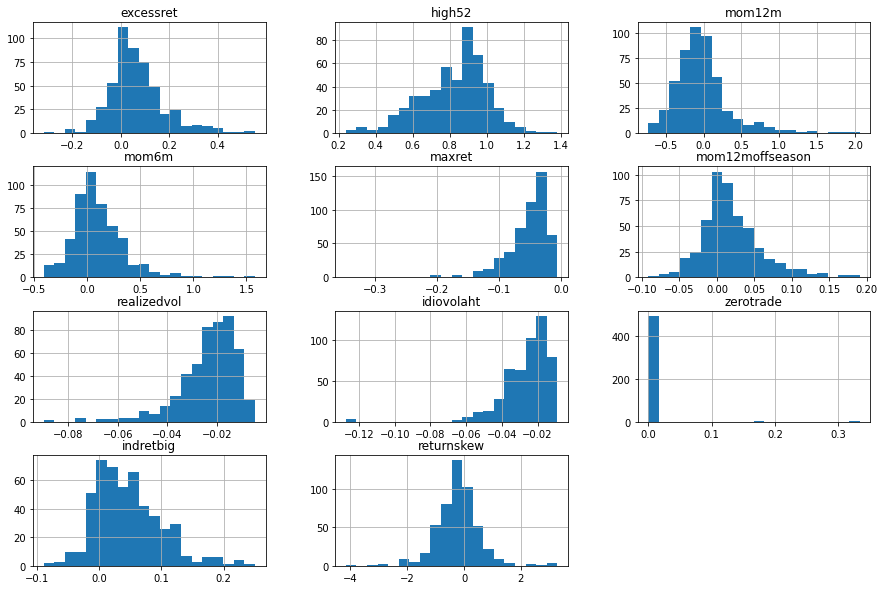


 ---------- Shapiro–Wilk Test ----------


,column,test_statistic,p-value,result
0,excessret,0.950918,7.897594e-12,Reject (Not Normal Distribution)
1,high52,0.981214,4.672652e-06,Reject (Not Normal Distribution)
2,mom12m,0.887379,1.198191e-18,Reject (Not Normal Distribution)
3,mom6m,0.904138,3.425063e-17,Reject (Not Normal Distribution)
4,maxret,0.785306,3.998836e-25,Reject (Not Normal Distribution)
5,mom12moffseason,0.942317,5.070707e-13,Reject (Not Normal Distribution)
6,realizedvol,0.880056,3.102203e-19,Reject (Not Normal Distribution)
7,idiovolaht,0.784044,3.454297e-25,Reject (Not Normal Distribution)
8,zerotrade,0.069653,1.064987e-43,Reject (Not Normal Distribution)
9,indretbig,0.960817,2.841696e-10,Reject (Not Normal Distribution)



 ---------- Spearman Correlation Matrix Plot ----------


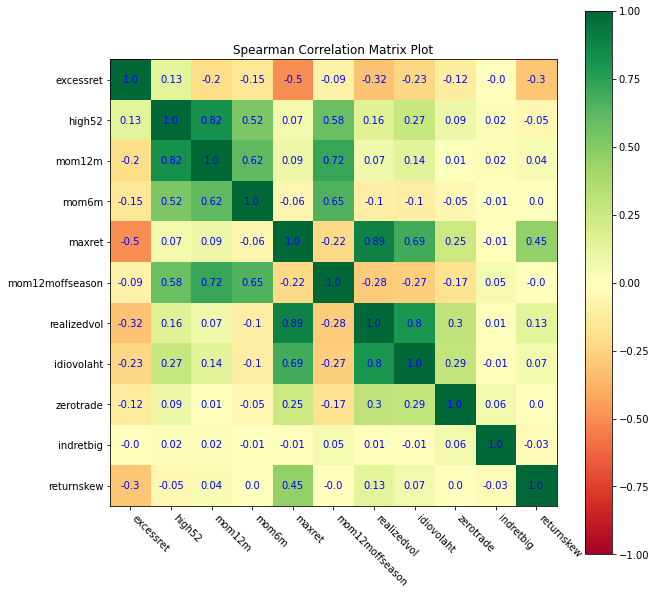

  0%|          | 0/1000000 [00:00<?, ?it/s]


 ---------- Model with Equal Range Discretization ----------


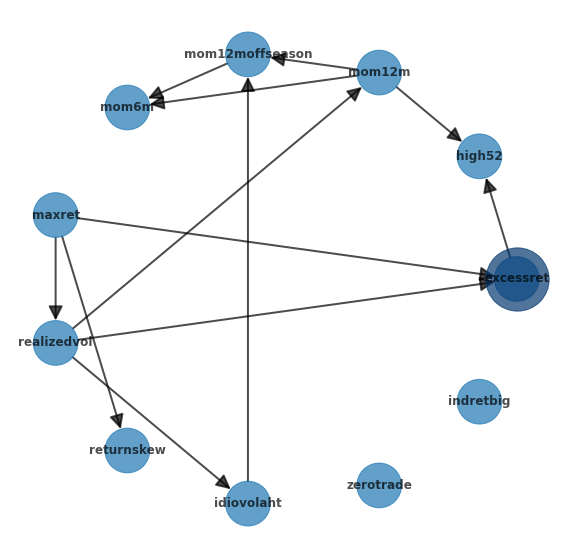

F1 score: 0.65
Accuracy score: 0.73
Precision score: 0.74
Recall score: 0.58
Log-likilihood score: -1038.67
Structure score: -1142.35


  0%|          | 0/1000000 [00:00<?, ?it/s]


 ---------- Model with Equal Frequency Discretization ----------


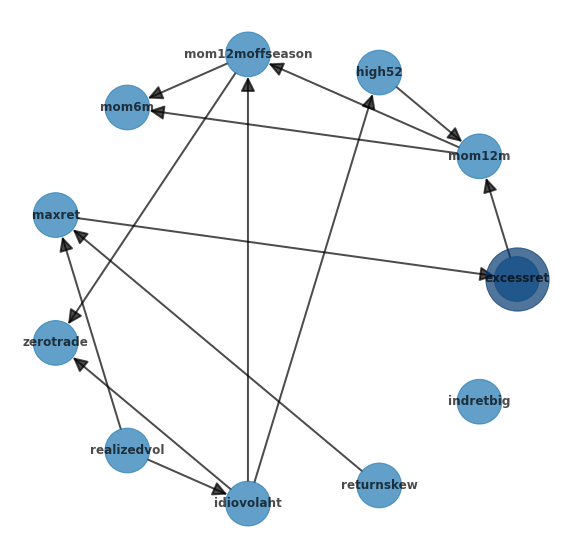

F1 score: 0.65
Accuracy score: 0.78
Precision score: 0.85
Recall score: 0.52
Log-likilihood score: -1927.81
Structure score: -2127.37

 ---------- Conditional Probability Table of Excess Return ----------

Check model: True

CPT of excessret:
+-----+---------------------------------+
| ... | maxret(4. More than: -0.0915)   |
+-----+---------------------------------+
| ... | realizedvol(4. More than: 0.12) |
+-----+---------------------------------+
| ... | 3.793418647166362               |
+-----+---------------------------------+
| ... | 81.93392530686864               |
+-----+---------------------------------+
| ... | 13.822146774614783              |
+-----+---------------------------------+
| ... | 0.45050927135022195             |
+-----+---------------------------------+ 

CPT of high52:
+-----+--------------------------------+
| ... | excessret(4. More than: 0.336) |
+-----+--------------------------------+
| ... | mom12m(4. More than: 1.365)    |
+-----+-----------------------

In [3]:
### Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from pgmpy.estimators import BayesianEstimator, ExpectationMaximization, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, r2_score

### Section 1: Data Set loading and Evaluation
rawFinance = pd.read_csv("finance_dataset.csv")
# display(rawFinance) # Display to check if the 'finance_dataset' is really for 1 quater

## Create DataFrame of the 'defined_variables' and the 'target_variable'
defined_columns = ['high52', 'mom12m', 'mom6m', 'maxret', 'mom12moffseason', 'realizedvol', 
                   'idiovolaht', 'zerotrade', 'indretbig', 'returnskew'] # focus features

"""
--------- Variables in this Analysis ---------
Excess Return (excessret) = excess return between quarter (positive = outperform, negative = under perform)
high52 = ratio of the present adjusted share price to the highest for the previous 52 weeks.
12-Month Momentum (mom12m) = 12-month momentum, speed at which the price is changing
6-Month Momentum (mom6m) = 6-month momentum, speed at which the price is changing
Maximize Return (maxret)
12-Month Momentum without seasonal component (mom12moffseason)
Realized Volatility (realizedvol)
Idiosyncratic Risk (idiovolaht)
Zero Trade (zerotrade) = 6-month average of days with no trades + (sum of monthly turnover / (40*10^5) * 21/(numbers of trading days))
Industry Returns of Big Firms (indretbig) = Monthly return average of 30% largest companies
Return Skew (returnskew) = Daily return skewness over previous month

--------- References: --------- 
Chen, A. Y., & Zimmermann, T. (2021). Open source cross-sectional asset pricing. 
    Critical Finance Review, Forthcoming.
Dhir, R. (2023) What is momentum? definition in trading, tools, and risks, Investopedia. 
    Available at: https://www.investopedia.com/terms/m/momentum.asp (Accessed: 03 February 2024). 
"""

unclean_finance = rawFinance[["excessret"] + defined_columns] # Response 'excess' + defined_columns
# rawFinance_defined.head() # Check Header

## Checking for data type and missing values
print("Dimensions: ", unclean_finance.shape) # Check dimension
print("\n", "-" * 10, "Check Data Type", "-" * 10)
print(unclean_finance.dtypes) # Check data type
print("\n", "-" * 10, "Check Missing Values (NA)", "-" * 10)
print(unclean_finance.isnull().any()) # Check missing values

### Section 2: Exploratory Data Analysis
## Subsection 2.1: Summary Table, Scatter Matrix and Histogram

## Display the summary table of our data
print("\n", "-" * 10, "Summary Statistics Table", "-" * 10)
display(unclean_finance.describe().transpose())

## Plotting the Scatter Matrix
print("\n", "-" * 10, "Scatter Matrix", "-" * 10)
pd.plotting.scatter_matrix(unclean_finance, figsize=(17, 15), alpha=0.4)
plt.show()

## Plotting the Histogram
print("\n", "-" * 10, "Histogram Plot", "-" * 10)
unclean_finance.hist(bins=20, figsize=(15, 10))
plt.show()

## Change the name to indicate that is is usable for further analysis
finance = unclean_finance

## Check for normal distribution assumption
def shapiroTest(df):
    """
    Test whether the data is normally distributed or not with shapiro test.
    For confidence interval of 95%, if p-value < 0.05, the column is not distributed normally.
    """
    results = [] # keeping all the shapiro test from all columns
    
    ## Run through the column names
    for a_col in df.columns:
        t_stat, p_value = shapiro(df[a_col])
        normal_status = "Fail to Reject (Normal Distribution)"
        ## Reject If p < 0.05
        if p_value < 0.05:
            normal_status = "Reject (Not Normal Distribution)"
        results.append({"column": a_col, "test_statistic": t_stat, "p-value": p_value, "result": normal_status})
        
    shapiro_result = pd.DataFrame(results)
    return shapiro_result

## Display the Normality test results
print("\n", "-" * 10, "Shapiro–Wilk Test", "-" * 10)
display(shapiroTest(finance))

## Ploting Correlation Plot
corr_matrix = finance.corr(method = "spearman")
fig, ax = plt.subplots(figsize = (10, 10))
plt.imshow(corr_matrix, cmap = "RdYlGn",vmin = -1, vmax = 1) # -1 to 1
plt.colorbar()

## Extract variable names
variables = [] # variables name list
for var in corr_matrix.columns:
    variables.append(var)

## Adding labels to the matrix
plt.xticks(range(len(corr_matrix)), variables, rotation = -45, ha="left")
plt.yticks(range(len(corr_matrix)), variables)

## Two loops to add pearson correlation among the variables
for i in range(len(variables)):
    for j in range(len(variables)):
        text = plt.text(j, i, round(corr_matrix.iloc[i,j], 2),
                      ha = "center", va="center", color="b")

## Display the plot
print("\n", "-" * 10, "Spearman Correlation Matrix Plot", "-" * 10)
plt.title("Spearman Correlation Matrix Plot")
plt.show()

### Section 3: Complex Bayesian Network
def makeDiscrete_eqrange(df):
    """
    This function discretize data into four equal ranges.
    """
    ## Bin labels
    excessret_labels = ["1. Less than: -0.101", "2. Between -0.101 and 0.118", "3. Between 0.118 and 0.336", "4. More than: 0.336"]
    high52_labels = ["1. Less than: 0.525", "2. Between 0.525 and 0.811", "3. Between 0.811 and 1.096", "4. More than: 1.096"]
    mom12m_labels = ["1. Less than: -0.0337", "2. Between -0.0337 and 0.665", "3. Between 0.665 and 1.365", "4. More than: 1.365"]
    mom6m_labels = ["1. Less than: 0.0884", "2. Between 0.0884 and 0.586", "3. Between 0.586 and 1.083", "4. More than: 1.083"]
    maxret_labels = ["1. Less than: -0.262", "2. Between -0.262 and -0.177", "3. Between -0.177 and -0.0915", "4. More than: -0.0915"]
    mom12moffseason_labels = ["1. Less than: -0.0213", "2. Between -0.0213 and -0.0492", "3. Between 0.0492 and 0.12", "4. More than: 0.12"]
    realizedvol_labels = ["1. Less than: -0.0213", "2. Between -0.0213 and -0.0492", "3. Between 0.0492 and 0.12", "4. More than: 0.12"]
    idiovolaht_labels = ["1. Less than: -0.0686", "2. Between -0.0686 and -0.0473", "3. Between -0.0473 and -0.026", "4. More than: -0.026"]
    zerotrade_labels = ["1. Less than: 0.0833", "2. Between 0.0833 and 0.167", "3. Between 0.167 and 0.25", "4. More than: 0.25"]
    indretbig_labels = ["1. Less than: -0.00437", "2. Between -0.00437 and 0.0806", "3. Between 0.0806 and 0.166", "4. More than: 0.166"]
    returnskew_labels = ["1. Less than: -2.3", "2. Between -2.3 and -0.439", "3. Between -0.439 and 1.422", "4. More than: 1.422"]

    discrete_df = pd.DataFrame() # Initialize a DataFrame
    ## Cut into 4 equal ranges
    discrete_df["excessret"] = pd.cut(df["excessret"], bins=4, labels=excessret_labels, precision=3)
    discrete_df["high52"] = pd.cut(df["high52"], bins=4, labels=high52_labels, precision=3)
    discrete_df["mom12m"] = pd.cut(df["mom12m"], bins=4, labels=mom12m_labels, precision=3)
    discrete_df["mom6m"] = pd.cut(df["mom6m"], bins=4, labels=mom6m_labels, precision=3)
    discrete_df["maxret"] = pd.cut(df["maxret"], bins=4, labels=maxret_labels, precision=3)
    discrete_df["mom12moffseason"] = pd.cut(df["mom12moffseason"], bins=4, labels=mom12moffseason_labels, precision=3)
    discrete_df["realizedvol"] = pd.cut(df["realizedvol"], bins=4, labels=realizedvol_labels, precision=3)
    discrete_df["idiovolaht"] = pd.cut(df["idiovolaht"], bins=4, labels=idiovolaht_labels, precision=3)
    discrete_df["zerotrade"] = pd.cut(df["zerotrade"], bins=4, labels=zerotrade_labels, precision=3)
    discrete_df["indretbig"] = pd.cut(df["indretbig"], bins=4, labels=indretbig_labels, precision=3)
    discrete_df["returnskew"] = pd.cut(df["returnskew"], bins=4, labels=returnskew_labels, precision=3)
    
    discrete_df = discrete_df.astype("object")
    return discrete_df 

def makeDiscrete_eqfreq(df):
    """
    This function discretize data into four equal frequency bins.
    """
    ## Bin labels 
    excessret_labq4 = ["1. Q1", "2. Q2", "3. Q3", "4. Q4"]
    high52_labq4 = ["1. Q1", "2. Q2", "3. Q3", "4. Q4"]
    mom12m_labq4 = ["1. Q1", "2. Q2", "3. Q3", "4. Q4"]
    mom6m_labq4 = ["1. Q1", "2. Q2", "3. Q3", "4. Q4"]
    maxret_labq4 = ["1. Q1", "2. Q2", "3. Q3", "4. Q4"]
    mom12moffseason_labq4 = ["1. Q1", "2. Q2", "3. Q3", "4. Q4"]
    realizedvol_labq4 = ["1. Q1", "2. Q2", "3. Q3", "4. Q4"]
    idiovolaht_labq4 = ["1. Q1", "2. Q2", "3. Q3", "4. Q4"]
    zerotrade_labq4 = ["1. Q1", "2. Q2", "3. Q3", "4. Q4"]
    indretbig_labq4 = ["1. Q1", "2. Q2", "3. Q3", "4. Q4"]
    returnskew_labq4 = ["1. Q1", "2. Q2", "3. Q3", "4. Q4"]
    
    discrete_df = pd.DataFrame() # Initialize a DataFrame
    ## Cut into 4 equal frequency, by quartile
    discrete_df["excessret"] = pd.qcut(df["excessret"], q=4, labels=excessret_labq4, precision=3)
    discrete_df["high52"] = pd.qcut(df["high52"], q=4, labels=high52_labq4, precision=3)
    discrete_df["mom12m"] = pd.qcut(df["mom12m"], q=4, labels=mom12m_labq4, precision=3)
    discrete_df["mom6m"] = pd.qcut(df["mom6m"], q=4, labels=mom6m_labq4, precision=3)
    discrete_df["maxret"] = pd.qcut(df["maxret"], q=4, labels=maxret_labq4, precision=3)
    discrete_df["mom12moffseason"] = pd.qcut(df["mom12moffseason"], q=4, labels=mom12moffseason_labq4, precision=3)
    discrete_df["realizedvol"] = pd.qcut(df["realizedvol"], q=4, labels=realizedvol_labq4, precision=3)
    discrete_df["idiovolaht"] = pd.qcut(df["idiovolaht"], q=4, labels=idiovolaht_labq4, precision=3)
    discrete_df["zerotrade"] = pd.qcut(df["zerotrade"], q=4, labels=zerotrade_labq4, precision=3)
    discrete_df["indretbig"] = pd.qcut(df["indretbig"], q=4, labels=indretbig_labq4, precision=3)
    discrete_df["returnskew"] = pd.qcut(df["returnskew"], q=4, labels=returnskew_labq4, precision=3)
    
    discrete_df = discrete_df.astype("object")
    return discrete_df

def plotBayesNet(model, training_data, target, n_nodes):
    """
    This function plot Bayesian Network with one target variable.
    """
    display(HTML("<style>div.output_area pre {white-space: pre;}</style>")) # White Space for plotting
    model.cpds = []
    ## Fit the training data into the model
    model.fit(data = training_data,
        estimator = BayesianEstimator,
        prior_type = "BDeu",
        complete_samples_only = True)

    plt.figure(3,figsize = (10, 10))
    G = nx.DiGraph()
    G.add_edges_from(model.edges) # Draw edges (the arrow)
    G.add_nodes_from(model.nodes) # Draw nodes (the circle)
    pos = nx.circular_layout(G) # Make it a circular layout
    DAG = G.to_directed()
    nx.topological_sort(DAG)
    nx.draw_networkx(G, pos = pos, with_labels = True,
                    node_size = [2000 for i in range(n_nodes)], # Using loops to create nodes
                    arrowsize = 30,
                    alpha = 0.7,
                    font_weight = "bold",
                    width = 2.0)  # Draw the whole network
    
    tt_g = G.subgraph(nodes = [target]) # Draw a graph on the target variable
    nx.draw(tt_g, pos = pos, with_labels = False, arrowsize = 0, node_size = 4000, 
            alpha = 0.7, font_weight = "bold", node_color ='#063970')
    
    plt.show() # Plot the figure

def modelEvaluation(model, testing_data):
    """
    This function provides the score of the Bayesian Model to evaluate between models.
    """
    f1 = correlation_score(model=model, data=testing_data, test="chi_square", 
                           significance_level=0.05, score=f1_score, return_summary=False)
    accuracy = correlation_score(model=model, data=testing_data, test="chi_square", 
                            significance_level=0.05, score=accuracy_score, return_summary=False)
    precision = correlation_score(model=model, data=testing_data, test="chi_square", 
                           significance_level=0.05, score=precision_score, return_summary=False)
    recall = correlation_score(model=model, data=testing_data, test="chi_square", 
                               significance_level=0.05, score=recall_score, return_summary=False)
    ## pgmpy scoring tests
    lls = log_likelihood_score(model=model, data=testing_data)
    ss = structure_score(model=model, data=testing_data, scoring_method="bdeu")
    
    print(f"F1 score: {round(f1, 2)}")
    print(f"Accuracy score: {round(accuracy, 2)}")
    print(f"Precision score: {round(precision, 2)}")
    print(f"Recall score: {round(recall, 2)}")
    print(f"Log-likilihood score: {round(lls, 2)}")
    print(f"Structure score: {round(ss, 2)}")

## Model with Equal Range Discretization
finance_eqRange = makeDiscrete_eqrange(finance) 
train_data1, test_data1 = train_test_split(finance_eqRange, test_size=0.3, random_state=20) # 30% test 70% train
hc = HillClimbSearch(data = train_data1)
estimate_1 = hc.estimate(scoring_method="k2score") # Select same estimate conditions for comparision
model_eqRange = BayesianNetwork(estimate_1)
print("\n", "-" * 10, "Model with Equal Range Discretization", "-" * 10)
plotBayesNet(model_eqRange, train_data1, "excessret", 11)
modelEvaluation(model_eqRange, test_data1) # Get equal range model test scores

## Model with Equal Frequency Discretization
finance_eqFreq = makeDiscrete_eqfreq(finance) 
train_data2, test_data2 = train_test_split(finance_eqFreq, test_size=0.3, random_state=20) # 30% test 70% train
hc = HillClimbSearch(data = train_data2)
estimate_2 = hc.estimate(scoring_method="k2score") # Select same estimate conditions for comparision
model_eqFreq = BayesianNetwork(estimate_2)
print("\n", "-" * 10, "Model with Equal Frequency Discretization", "-" * 10)
plotBayesNet(model_eqFreq, train_data2, "excessret", 11)
modelEvaluation(model_eqFreq, test_data2) # Get equal frequency model test scores

## Under the assumption that we are using our model for explanation.
## We select equal range model over equal frequency Model

## Printed out the CPT table for the selected model
## Extract the Conditional Probability Table (CPT)
def getCPT(model):
    """
    This function prints out the conditional probability table as percentage.
    """
    print(f"\nCheck model: {model.check_model()}\n") 
    for cpd in model.get_cpds(): # return the list of nodes
        print(f"CPT of {cpd.variable}:") # print each variable
        print(cpd*100, "\n") # convert into %

print("\n", "-" * 10, "Conditional Probability Table of Excess Return", "-" * 10)
getCPT(model_eqRange) # print out equal range model CPT

### Write your description in the following space.

This question analysis is divided into three sections: data evaluation, exploration, and Bayesian probabilistic network. After missing value and data type evaluation, we plotted a scatter matrix and correlation matrix among all the variables. These plots indicated that most of the variables are not normally distributed, as the histogram plot indicates distribution skewness. To confirm this assumption, the Shapiro-Wilk test is conducted to test the normal distribution hypothesis. As the p-values are less than 0.05, we can conclude that all the variables are not distributed normally. Therefore, we employed a Spearman Correlation instead of Pearson Correlation, which requires a normal distribution assumption, to explore the relationship among the variables. From the matrix plot, we found out that maximize return (maxret) and realized volatility (realizedvol) have a moderate and low negative relationship with the excess return (excessret), respectively. Other variables have a minuscule negative correlation with the excessret only high52 has a low positive relationship.

With the focus on analyzing the defined features which have the highest probabilistic relationship with the excessret, the Bayesian Network model is selected over Tree Augment Naïve Bayes, as we are evaluating the relationship among variables. Also, it is essential to establish that the primary focus of this model is to explore the relationship rather than for prediction. As the discretization process affects the final model, we will be comparing between equal bins (4) and equal frequency (quartile) model scores. The equal frequency discretization model has a high accuracy and precision score at 0.78 and 0.85 when compared to the equal bin range model at 0.73 and 0.74. This makes the equal frequency model a better prediction model. Nevertheless, as we are focusing on explaining the model, the log-likelihood parameter and structure score are the metrics of focus. Both measurements measure how the model could describe the data with a higher score indicating a better fit (Ankan, no date). Therefore, the equal bin model will be focused on (lower negative values). From the Bayesian Network plot, it can be identified that maxret and realizedvol are the two defined features that have the highest probabilistic relationship with the excess return. This result aligns with the correlation matrix, where these two variables' relationships are prominent. A conditional probability table for this model which provides the probability of an event is printed out. However, due to the limited display of the Jupyter Notebook, the table is truncated.

<b> Word Count: </b> (398 words) <br>

<b> References: </b> <br>
Ankan, A. (no date) Metrics for testing models, Metrics for testing models - pgmpy 0.1.23 documentation. Available at: https://pgmpy.org/metrics/metrics.html (Accessed: 05 February 2024). 